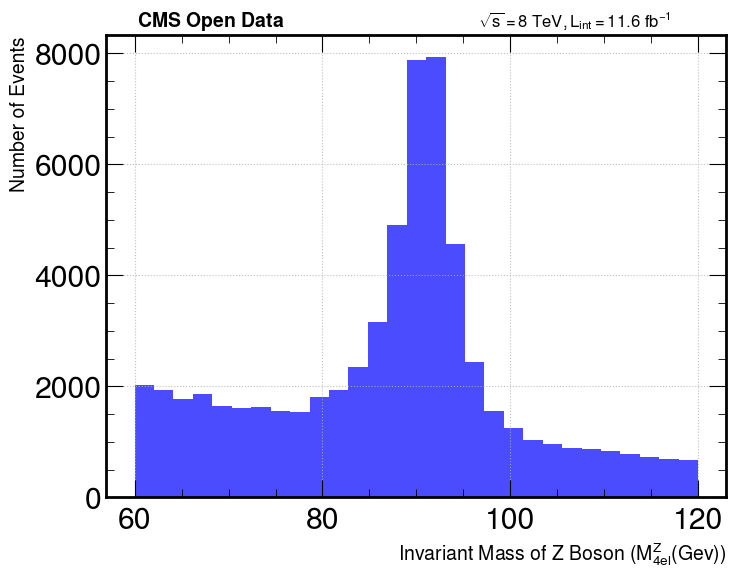

Standard Deviation:  Invariant Mass of Z Boson ($M_{4el}^Z$(Gev)) 20.375399
Mean:  Invariant Mass of Z Boson ($M_{4el}^Z$(Gev)) 77.06967


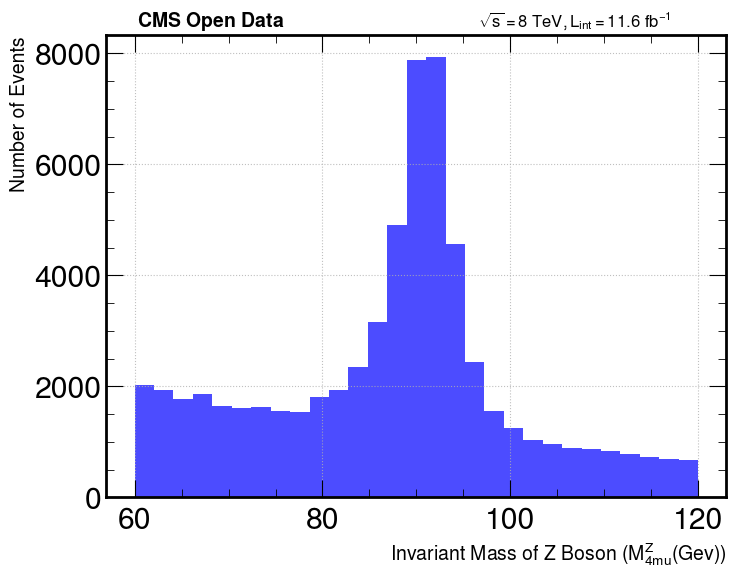

Standard Deviation:  Invariant Mass of Z Boson ($M_{4mu}^Z$(Gev)) 20.5119
Mean:  Invariant Mass of Z Boson ($M_{4mu}^Z$(Gev)) 76.30958


In [58]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import vector
import mplhep as heps

#Week 2 of actually doing stuff
#Create ZZ (2 Z bosons) to 4e (4 electrons) and ZZ to 2e 2mu (2 electron, 2 muons) and ZZ to 4mu #(4 muons)
#Higgs -> ZZ -> any four leptons (ignoring neutrinos)


# Register vector to use with awkward arrays
vector.register_awkward()

# Set CMS style for the plots
plt.style.use(hep.style.CMS)

def masking(z1_mass, z2_mass):
    z1_mask = (z1_mass > 40) & (z1_mass < 120)
    z2_mask = (z2_mass > 40) & (z2_mass < 120)

    # Mask events based on Z mass windows
    selected_z1_mass = z1_mass[z1_mask]
    selected_z2_mass = z2_mass[z2_mask]

    return selected_z1_mass, selected_z2_mass

def reco_Z_to_4mu(events):
    # Apply the selection to filter events with at least 4 muons
    events = selection_4mu(events)

    # Reconstruct Z bosons using the four-momentum components of electrons and muons
    z1_mass, z2_mass = compute_z_masses_4mu(
        events.Muon_pt, events.Muon_eta, events.Muon_phi, events.Muon_mass)

    selected_z1_mass, selected_z2_mass = masking(z1_mass, z2_mass)
    
    return selected_z1_mass, selected_z2_mass

def reco_Z_to_4el(events):
    """Reconstruct Z bosons from four electrons"""

    # Apply the selection to filter events with at least 4 electrons
    events = selection_4el(events)

    # Reconstruct Z bosons using the four-momentum components of electrons
    z1_mass, z2_mass = compute_z_masses_4el(
        events.Electron_pt, events.Electron_eta, events.Electron_phi, events.Electron_mass)

    # Mask events based on Z mass windows
    selected_z1_mass, selected_z2_mass = masking(z1_mass, z2_mass)

    return selected_z1_mass, selected_z2_mass

def reco_Z_to_2e2mu(events):
        # Apply the selection to filter events with at least 2 electrons and 2 muons
    events = selection_2e2mu(events)

    # Reconstruct Z bosons using the four-momentum components of electrons and muons
    z1_mass, z2_mass = compute_z_masses_2e2mu(events.Muon_pt, events.Muon_eta, events.Muon_phi, events.Muon_mass,
        events.Electron_pt, events.Electron_eta, events.Electron_phi, events.Electron_mass)

    # Mask events based on Z mass windows
    selected_z1_mass, selected_z2_mass = masking(z1_mass, z2_mass)

    return selected_z1_mass, selected_z2_mass

#selections
def selection_4mu(events):
    """Select events with at least four muons"""

    # Mask for electrons: at least 2 electrons with |eta| < 2.5
    muon_mask = (events["nMuon"] >= 4) & (ak.all(np.abs(events["Muon_eta"]) < 2.5, axis=1)) & (ak.all(np.abs(events["Muon_pt"]) > 7, axis=1)) 
    
    #check for two positively charged muons, and for two negatively charged muons (antimuons)
    
    selected_events = events[muon_mask] 
    
    return selected_events

def selection_4el(events):
    """Select events with at least two electrons and two muons"""

    # Mask for electrons: at least 2 electrons with |eta| < 2.5
    electron_mask = (events["nElectron"] >= 4) & (ak.all(np.abs(events["Electron_eta"]) < 2.5, axis=1)) &(ak.all(np.abs(events["Electron_pt"]) > 7, axis=1)) 
    combined_mask = electron_mask
    
        # Apply additional selection criteria here:
    # Isolation cut: Electron_pfRelIso03_all < 0.40 for all electrons
    # Define Electron_ip3d: sqrt(Electron_dxy^2 + Electron_dz^2)
    # Define Electron_sip3d: Electron_ip3d / sqrt(Electron_dxyErr^2 + Electron_dzErr^2)
    # Additional selection: Electron_sip3d < 4, |Electron_dxy| < 0.5, |Electron_dz| < 1.0
    # Apply final selection: events with exactly 4 electrons
    # Charge balance selection: 2 positive and 2 negative electrons
    # Apply the combined mask to select events
    
    selected_events = events[electron_mask] 
    
    return selected_events
def selection_2e2mu(events):
    """Select events with at least 2 electrons and 2 muons"""
    
    # Mask for electrons: at least 2 electrons with |eta| < 2.5
    muon_mask = (events["nMuon"] >= 2) & (ak.all(np.abs(events["Muon_eta"]) < 2.5, axis=1)) & (ak.all(np.abs(events["Muon_pt"]) > 7, axis=1)) 
    electron_mask = (events["nElectron"] >= 2) & (ak.all(np.abs(events["Electron_eta"]) < 2.5, axis=1)) & (ak.all(np.abs(events["Electron_pt"]) > 7, axis=1)) 
    #check for muon, electron, antimuon, and positron
    
    selected_events = events[muon_mask & electron_mask] 
    return selected_events

#computations
def compute_z_masses_4mu(Muon_pt, Muon_eta, Muon_phi, Muon_mass):
    # Create Lorentz vectors for muons using awkwardarrays and vector
    muon_p4 = ak.zip({
        "pt": Muon_pt,
        "eta": Muon_eta,
        "phi": Muon_phi,
        "mass": Muon_mass
    }, with_name="PtEtaPhiMLorentzVector")
    
    # Convert awkward arrays to vector.Array
    muon_vec = vector.awk(ak.Array(muon_p4))
    # Form Z candidates by adding the appropriate four-momenta
    z1 = muon_vec[:, 0] + muon_vec[:, 1]  # First Z candidate (from electrons)
    z2 = muon_vec[:, 2] + muon_vec[:, 3]  # First Z candidate (from electrons)
    
    # Compute invariant masses
    z1_mass = z1.mass
    z2_mass = z2.mass

    return z1_mass, z2_mass

# Define a function to compute the Z masses from four electrons
def compute_z_masses_4el(electron_pt, electron_eta, electron_phi, electron_mass):
    
    # Create Lorentz vectors for electrons and muons using awkward and vector
    electron_p4 = ak.zip({
        "pt": electron_pt,
        "eta": electron_eta,
        "phi": electron_phi,
        "mass": electron_mass
    }, with_name="PtEtaPhiMLorentzVector")
    
    
    
    # Convert awkward arrays to vector.Array
    electron_vec = vector.awk(ak.Array(electron_p4))

    # Form Z candidates by adding the appropriate four-momenta
    z1 = electron_vec[:, 0] + electron_vec[:, 1]  # First Z candidate (from electrons)
    z2 = electron_vec[:, 2] + electron_vec[:, 3]  # First Z candidate (from electrons)
    
    # Compute invariant masses
    z1_mass = z1.mass
    z2_mass = z2.mass

    return z1_mass, z2_mass

def compute_z_masses_2e2mu(Muon_pt, Muon_eta, Muon_phi, Muon_mass, electron_pt, electron_eta, electron_phi, electron_mass):
    # Create Lorentz vectors for muons and electrons using awkwardarrays and vector
    muon_p4 = ak.zip({
        "pt": Muon_pt,
        "eta": Muon_eta,
        "phi": Muon_phi,
        "mass": Muon_mass
    }, with_name="PtEtaPhiMLorentzVector")
    
    electron_p4 = ak.zip({
        "pt": electron_pt,
        "eta": electron_eta,
        "phi": electron_phi,
        "mass": electron_mass
    })
    # Convert awkward arrays to vector.Array
    muon_vec = vector.awk(ak.Array(muon_p4))
    electron_vec = vector.awk(ak.Array(electron_p4))
    
    # Form Z candidates by adding the appropriate four-momenta
    z1 = muon_vec[:, 0] + muon_vec[:, 1]  # First Z candidate (from muons)
    z2 = electron_vec[:, 0] + electron_vec[:, 1]  # First Z candidate (from electrons)
    
    # Compute invariant masses
    z1_mass = z1.mass
    z2_mass = z2.mass

    return z1_mass, z2_mass

def plot_z_mass(z_mass, x_label):
    # Create histogram bins
    bins = np.linspace(60, 120, 30)  # 30 Bins from 60 to 120 GeV

    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(8, 6))  # Width of 8 inches and height of 6 inches

    # Plot the Z mass histogram
    ax.hist(z_mass, bins=bins, histtype='stepfilled', color='blue', alpha=0.7, linewidth=2)

    # Add labels and title
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel('Number of Events', fontsize=14)

    # CMS-style text
    ax.text(0.05, 1.02, r'$\mathbf{CMS \ Open \ Data}$', transform=ax.transAxes, fontsize=14)
    ax.text(0.6, 1.02, r'$\sqrt{s} = 8 \ \mathrm{TeV}, L_{int} = 11.6 \ \mathrm{fb}^{-1}$', 
            transform=ax.transAxes, fontsize=12)

    # Display the plot
    plt.grid(True)
    plt.show()
    
# Load data from ROOT file using uproot
file_4e = uproot.open('/home/bhanda25/Phys323_fall2024/Root_files/ZZTo4e.root')
file_4mu = uproot.open('/home/bhanda25/Phys323_fall2024/Root_files/ZZTo4mu.root')
file_2e2mu = uproot.open('/home/bhanda25/Phys323_fall2024/Root_files/ZZTo2e2mu.root')
tree_4e = file_4e["Events"]
tree_4mu = file_4mu["Events"]
tree_2e2mu = file_2e2mu["Events"]
branches_4e = tree_4e.arrays(["nElectron", "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass"], library="ak")
branches_4mu = tree_4mu.arrays(["nMuon", "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass"], library="ak")
branches_2e2mu = tree_2e2mu.arrays(["nMuon", "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", "nElectron", 
                                      "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass"], library="ak")
def createGraphs(z1_mass, z2_mass, label):
    all_z_masses = ak.concatenate([z1_mass, z2_mass])
    z_mass_np = ak.to_numpy(all_z_masses)
    plot_z_mass(z_mass_np_4el, label)
    #Calculate Mean and Standard Deviation:
    print("Standard Deviation: ", label, np.std(z_mass_np))
    print("Mean: ", label, np.mean(z_mass_np))
# Reconstruct Z bosons and retrieve invariant masses

z1_mass, z2_mass = reco_Z_to_4el(branches_4e)
createGraphs(z1_mass, z2_mass, "Invariant Mass of Z Boson ($M_{4el}^Z$(Gev))")
z3_mass, z4_mass = reco_Z_to_4mu(branches_4mu)
createGraphs(z3_mass, z4_mass, "Invariant Mass of Z Boson ($M_{4mu}^Z$(Gev))")



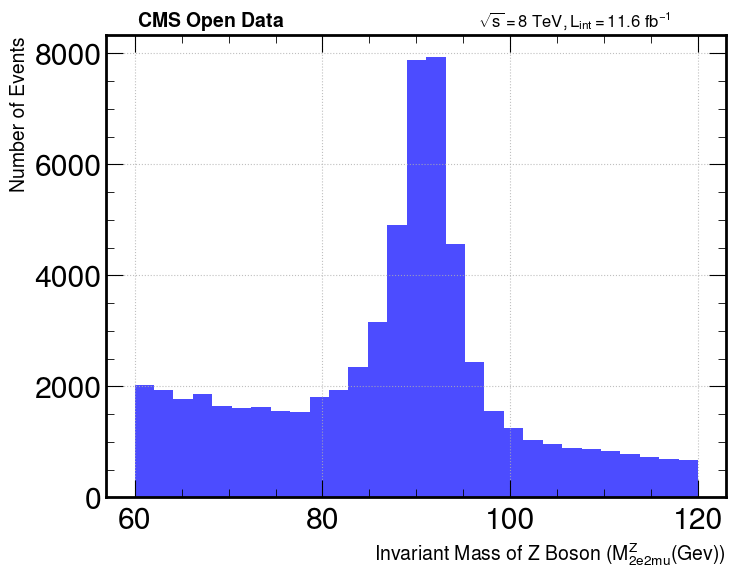

Standard Deviation:  Invariant Mass of Z Boson ($M_{2e2mu}^Z$(Gev)) 14.05125
Mean:  Invariant Mass of Z Boson ($M_{2e2mu}^Z$(Gev)) 84.933945


In [57]:
z5_mass, z6_mass = reco_Z_to_2e2mu(branches_2e2mu)
createGraphs(z5_mass, z6_mass, "Invariant Mass of Z Boson ($M_{2e2mu}^Z$(Gev))")

In [32]:
# Analysis and Reporting
# • Task 4.1: Analyze the distribution of Z boson masses. Look for any patterns
# or anomalies and compare the results to the expected mass window
# for Z bosons (typically around 91 GeV).

# • Task 4.2: Write a brief report summarizing your findings, including the
# distribution of Z boson masses and any interesting observations. I recom
# mend that you calculate the mean and standard deviation of the plot.

In [33]:
# The distrubution of Z boson masses is fairly uniform with a peak around 
# 90 GeV in the invariant mass category. The data seems to taper off after 
# 100 GeV and there seems to be a slight uptick around 60 GeV (going to the
# left). The results are exactly where we would expect the mass window for
# Z bosons to be of around 91 GeV. Maybe around 92 GeV. However the mean
# of 77 GeV is quite far from the mode of our data set which is spot on the
# particle money at 92 GeV. The relatively high standard deviation of +/-
# 20.375 GeV would be concerning if it didn't include our desired value but 
# it also suggests that there are more Z bosons with masses lower than our
# expected value than those that are higher than our expected value, which 
# indicates a possible bias in our data collection or error in our analysis.
# Either way though, the range provided by 77 +/- 20.375 GeV does include
# the 91 GeV for Z bosons and their expected energies. 